In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor
from scipy import stats
import shap
from pdpbox import pdp
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')


/media/i666sapple/Volume2/Sharjil/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def inspect_cleaned_data(df):
    """
    Display detailed information about the cleaned dataset
    """
    print("\nCleaned Dataset Information:")
    print("-" * 50)
    print("\nSample of processed data:")
    print(df.head())
    
    print("\nMissing values summary:")
    print(df.isnull().sum())
    
    print("\nService type distribution:")
    print(df['SERVICE_NAME'].value_counts())
    
    print("\nWaiting time statistics (in minutes):")
    print(df['waiting_time'].describe())
    
    return df


In [3]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess tab-separated data with proper column handling
    """
    try:
        # Read the tab-separated file
        df = pd.read_csv(file_path, sep='\t')
        
        # Convert timestamps to datetime
        timestamp_cols = ['SDST', 'SDET', 'TKIS_TIME']
        for col in timestamp_cols:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Remove rows with missing timestamps
        df = df.dropna(subset=['SDST', 'TKIS_TIME'])
        
        # Calculate waiting time in minutes
        df['waiting_time'] = (df['SDST'] - df['TKIS_TIME']).dt.total_seconds() / 60
        
        # Remove invalid waiting times (negative or extremely large values)
        df = df[df['waiting_time'] >= 0]
        
        # Remove outliers using IQR method
        Q1 = df['waiting_time'].quantile(0.25)
        Q3 = df['waiting_time'].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df['waiting_time'] < (Q1 - 1.5 * IQR)) | 
                  (df['waiting_time'] > (Q3 + 1.5 * IQR)))]
        
        # Extract temporal features
        for col in ['SDST', 'TKIS_TIME']:
            df[f'{col}_hour'] = df[col].dt.hour
            df[f'{col}_minute'] = df[col].dt.minute
            df[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df[f'{col}_is_weekend'] = df[col].dt.dayofweek.isin([5, 6]).astype(int)
            df[f'{col}_time_of_day'] = pd.cut(df[col].dt.hour, 
                                             bins=[0, 6, 12, 17, 24],
                                             labels=['night', 'morning', 'afternoon', 'evening'])
        
        # Basic data quality checks
        print("\nData Quality Report:")
        print("-" * 50)
        print(f"Total rows after cleaning: {len(df)}")
        print(f"Number of unique services: {df['SERVICE_NAME'].nunique()}")
        print(f"Average waiting time: {df['waiting_time'].mean():.2f} minutes")
        print(f"Median waiting time: {df['waiting_time'].median():.2f} minutes")
        
        return df
    
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        raise

In [4]:
def engineer_features(df):
    # Time-based features
    df['is_rush_hour'] = ((df['TKIS_TIME_hour'].isin([9, 10, 11, 14, 15, 16])) & 
                         (~df['TKIS_TIME_is_weekend'])).astype(int)
    
    # Service load features
    df['hourly_service_count'] = df.groupby(['SERVICE_NAME', 'TKIS_TIME_hour']).cumcount()
    df['service_load'] = df.groupby('TKIS_TIME_hour')['SERVICE_NAME'].transform('count')
    
    # Rolling statistics with different windows
    windows = [3, 5, 10, 15]
    for window in windows:
        # Service-specific rolling stats
        df[f'rolling_mean_wait_{window}'] = (
            df.groupby('SERVICE_NAME')['waiting_time']
            .rolling(window, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )
        df[f'rolling_std_wait_{window}'] = (
            df.groupby('SERVICE_NAME')['waiting_time']
            .rolling(window, min_periods=1)
            .std()
            .reset_index(0, drop=True)
        )
        
        # Time-based rolling stats
        df[f'hourly_rolling_mean_{window}'] = (
            df.groupby('TKIS_TIME_hour')['waiting_time']
            .rolling(window, min_periods=1)
            .mean()
            .reset_index(0, drop=True)
        )
    
    # Service complexity metrics
    service_metrics = df.groupby('SERVICE_NAME').agg({
        'waiting_time': ['mean', 'std', 'median', 'count'],
        'service_load': 'mean'
    }).reset_index()
    
    service_metrics.columns = ['SERVICE_NAME', 'avg_wait', 'std_wait', 
                             'median_wait', 'total_services', 'avg_load']
    
    service_metrics['complexity_score'] = (
        service_metrics['avg_wait'] * 
        service_metrics['std_wait'] * 
        np.log1p(service_metrics['avg_load'])
    )
    
    df = df.merge(service_metrics, on='SERVICE_NAME')
    
    return df

In [5]:
def perform_extensive_eda(df):
    # Set plotting style
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3
    
    # 1. Temporal Analysis
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # Hourly patterns
    sns.boxplot(data=df, x='TKIS_TIME_hour', y='waiting_time', ax=axes[0,0])
    axes[0,0].set_title('Waiting Time Distribution by Hour')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Waiting Time (minutes)')
    
    # Daily patterns
    sns.boxplot(data=df, x='TKIS_TIME_dayofweek', y='waiting_time', ax=axes[0,1])
    axes[0,1].set_title('Waiting Time Distribution by Day of Week')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Waiting Time (minutes)')
    
    # Service load by hour
    sns.barplot(data=df.groupby('TKIS_TIME_hour')['service_load'].mean().reset_index(),
                x='TKIS_TIME_hour', y='service_load', ax=axes[1,0])
    axes[1,0].set_title('Average Service Load by Hour')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Average Number of Services')
    
    # Waiting time distribution
    sns.histplot(data=df, x='waiting_time', bins=50, ax=axes[1,1])
    axes[1,1].set_title('Distribution of Waiting Times')
    axes[1,1].set_xlabel('Waiting Time (minutes)')
    plt.tight_layout()
    plt.show()
    
    # 2. Service Analysis
    plt.figure(figsize=(15, 8))
    service_stats = df.groupby('SERVICE_NAME').agg({
        'waiting_time': ['mean', 'std', 'count']
    }).reset_index()
    service_stats.columns = ['SERVICE_NAME', 'mean_wait', 'std_wait', 'count']
    
    service_stats = service_stats.sort_values('mean_wait', ascending=False)
    
    plt.errorbar(x=range(len(service_stats)), 
                y=service_stats['mean_wait'],
                yerr=service_stats['std_wait'],
                fmt='o',
                capsize=5)
    plt.xticks(range(len(service_stats)), 
               service_stats['SERVICE_NAME'],
               rotation=45,
               ha='right')
    plt.title('Average Waiting Time by Service (with standard deviation)')
    plt.tight_layout()
    plt.show()
    
    # 3. Correlation Analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
    
    # 4. Service Load Analysis
    plt.figure(figsize=(15, 6))
    pivot_data = df.pivot_table(
        values='service_load',
        index='TKIS_TIME_hour',
        columns='TKIS_TIME_dayofweek',
        aggfunc='mean'
    )
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Service Load Heatmap (Hour vs Day of Week)')
    plt.tight_layout()
    plt.show()

In [6]:
def prepare_features(df):
    # Select features for modeling
    feature_columns = [
        'TKIS_TIME_hour', 'TKIS_TIME_minute', 'TKIS_TIME_dayofweek',
        'TKIS_TIME_is_weekend', 'is_rush_hour', 'service_load',
        'hourly_service_count', 'complexity_score', 'avg_wait',
        'std_wait', 'median_wait', 'avg_load'
    ]
    
    # Add rolling statistics
    rolling_cols = [col for col in df.columns if 'rolling' in col]
    feature_columns.extend(rolling_cols)
    
    # Encode categorical variables
    categorical_features = ['SERVICE_NAME', 'TKIS_TIME_time_of_day']
    le = LabelEncoder()
    for cat_feat in categorical_features:
        df[f'{cat_feat}_encoded'] = le.fit_transform(df[cat_feat])
        feature_columns.append(f'{cat_feat}_encoded')
    
    X = df[feature_columns]
    y = df['waiting_time']
    
    # Scale features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    return X_scaled, y, feature_columns

In [7]:
def create_models():
    from xgboost import XGBRegressor
    
    catboost = CatBoostRegressor(
        iterations=600,
        learning_rate=0.02,
        depth=8,
        l2_leaf_reg=3,
        bootstrap_type='Bernoulli',
        subsample=0.8,
        verbose=100,  # Print updates every 100 iterations
        random_state=42
    )
    
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )
    
    # gbm = GradientBoostingRegressor(
    #     n_estimators=300,
    #     learning_rate=0.03,
    #     max_depth=8,
    #     min_samples_split=4,
    #     min_samples_leaf=2,
    #     subsample=0.8,
    #     max_features='sqrt',
    #     random_state=42
    # )
    
    xgb = XGBRegressor(
        n_estimators=600,
        learning_rate=0.02,
        max_depth=8,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        n_jobs=-1,
        verbosity=1,  # Print training progress
        random_state=42
    )
    
    ensemble = VotingRegressor(
        estimators=[
            ('catboost', catboost),
            ('rf', rf),
            ('xgb', xgb)
        ],
        weights=[2, 1, 2]
    )
    
    return {
        'CatBoost': catboost,
        'Random Forest': rf,
        'XGBoost': xgb,
        'Voting Ensemble': ensemble
    }

In [8]:
def train_and_evaluate_models(X, y):
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    models = create_models()
    results = {}
    tscv = TimeSeriesSplit(n_splits=5)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if hasattr(model, 'verbose'):
            print(f"{name} is training with verbose mode on.")
        
        cv_scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        print(f"Cross-validation completed for {name}.")
        print(f"CV RMSE Scores: {[-score for score in cv_scores]}")
        
        model.fit(X_train, y_train)
        print(f"{name} training completed.")
        
        y_pred = model.predict(X_test)
        print(f"{name} predictions completed.")
        
        metrics = {
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred),
            'cv_rmse': -np.mean(cv_scores),
            'cv_rmse_std': np.std(cv_scores)
        }
        
        results[name] = metrics
        print(f"\n{name} Performance Metrics:")
        print(f"Cross-validation RMSE: {-np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
        for metric, value in metrics.items():
            if metric not in ['cv_rmse', 'cv_rmse_std']:
                print(f"{metric.upper()}: {value:.4f}")
    
    best_model = min(results.items(), key=lambda x: x[1]['rmse'])
    print(f"\nBest performing model: {best_model[0]}")
    
    return models, results, X_train, X_test, y_train, y_test

In [9]:
def perform_comprehensive_xai(models, X_train, X_test, y_train, y_test, feature_columns):
    print("\nPerforming Comprehensive XAI Analysis...")
    
    # 1. Feature Importance Analysis
    if 'Random Forest' in models:
        rf_model = models['Random Forest']
        rf_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=rf_importance.head(15), x='importance', y='feature')
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features (Random Forest):")
        print(rf_importance.head(10))
    
    # # 2. SHAP Analysis
    # print("\nPerforming SHAP Analysis...")
    # explainer = shap.TreeExplainer(models['Random Forest'])
    # shap_values = explainer.shap_values(X_test)
    
    # plt.figure(figsize=(12, 8))
    # # Continue from previous SHAP analysis...
    # shap.summary_plot(shap_values, X_test, feature_names=feature_columns)
    # plt.title('SHAP Summary Plot')
    # plt.tight_layout()
    # plt.show()
    
    # # Sample feature dependencies
    # important_features = ['service_load', 'complexity_score', 'hourly_service_count']
    # for feature in important_features:
    #     feature_idx = feature_columns.index(feature)
    #     plt.figure(figsize=(10, 6))
    #     shap.dependence_plot(
    #         feature_idx,
    #         shap_values,
    #         X_test,
    #         feature_names=feature_columns
    #     )
    #     plt.title(f'SHAP Dependence Plot: {feature}')
    #     plt.tight_layout()
    #     plt.show()
    
    # 3. Model Performance Analysis
    print("\nAnalyzing Model Performance...")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        errors = y_test - y_pred
        
        # Error distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(errors, bins=50)
        plt.title(f'Prediction Error Distribution - {name}')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        print(f"\nError Statistics for {name}:")
        print(f"Mean Error: {np.mean(errors):.4f}")
        print(f"Error Standard Deviation: {np.std(errors):.4f}")
        print(f"Error Range: [{np.min(errors):.4f}, {np.max(errors):.4f}]")

In [10]:
def main(csv_path):
    """
    Main execution function
    """
    try:
        # Load and preprocess data
        print("Loading and preprocessing data...")
        df = load_and_preprocess_data(csv_path)
        
        # Inspect cleaned data
        print("\nInspecting cleaned data...")
        inspect_cleaned_data(df)
        
        # Feature engineering
        print("\nPerforming feature engineering...")
        df = engineer_features(df)
        
        # Exploratory Data Analysis
        print("\nPerforming exploratory data analysis...")
        perform_extensive_eda(df)
        
        # Prepare features for modeling
        print("\nPreparing features for modeling...")
        X, y, feature_columns = prepare_features(df)
        
        # Train and evaluate models
        print("\nTraining and evaluating models...")
        models, results, X_train, X_test, y_train, y_test = train_and_evaluate_models(X, y)
        
        # Perform XAI analysis
        print("\nPerforming XAI analysis...")
        perform_comprehensive_xai(models, X_train, X_test, y_train, y_test, feature_columns)
        
        return models, results, df
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Starting waiting time analysis...
Loading and preprocessing data...

Data Quality Report:
--------------------------------------------------
Total rows after cleaning: 266832
Number of unique services: 30
Average waiting time: 16.68 minutes
Median waiting time: 10.45 minutes

Inspecting cleaned data...

Cleaned Dataset Information:
--------------------------------------------------

Sample of processed data:
                 SDST                SDET              SERVICE_NAME  \
0 2020-07-28 13:37:12 2020-07-28 13:37:25     Deposit (Current/SND)   
1 2020-07-28 13:37:25 2020-07-28 13:37:27  Withdrawal (Current/SND)   
2 2020-07-28 15:37:47 2020-07-28 15:37:49                Withdrawal   
3 2020-07-28 15:46:07 2020-07-28 16:04:53                Debit Card   
4 2020-07-28 15:40:56 2020-07-28 15:41:49                     Agent   

            TKIS_TIME  waiting_time  SDST_hour  SDST_minute  SDST_dayofweek  \
0 2020-07-28 13:37:11      0.016667         13           37               1   
1 2

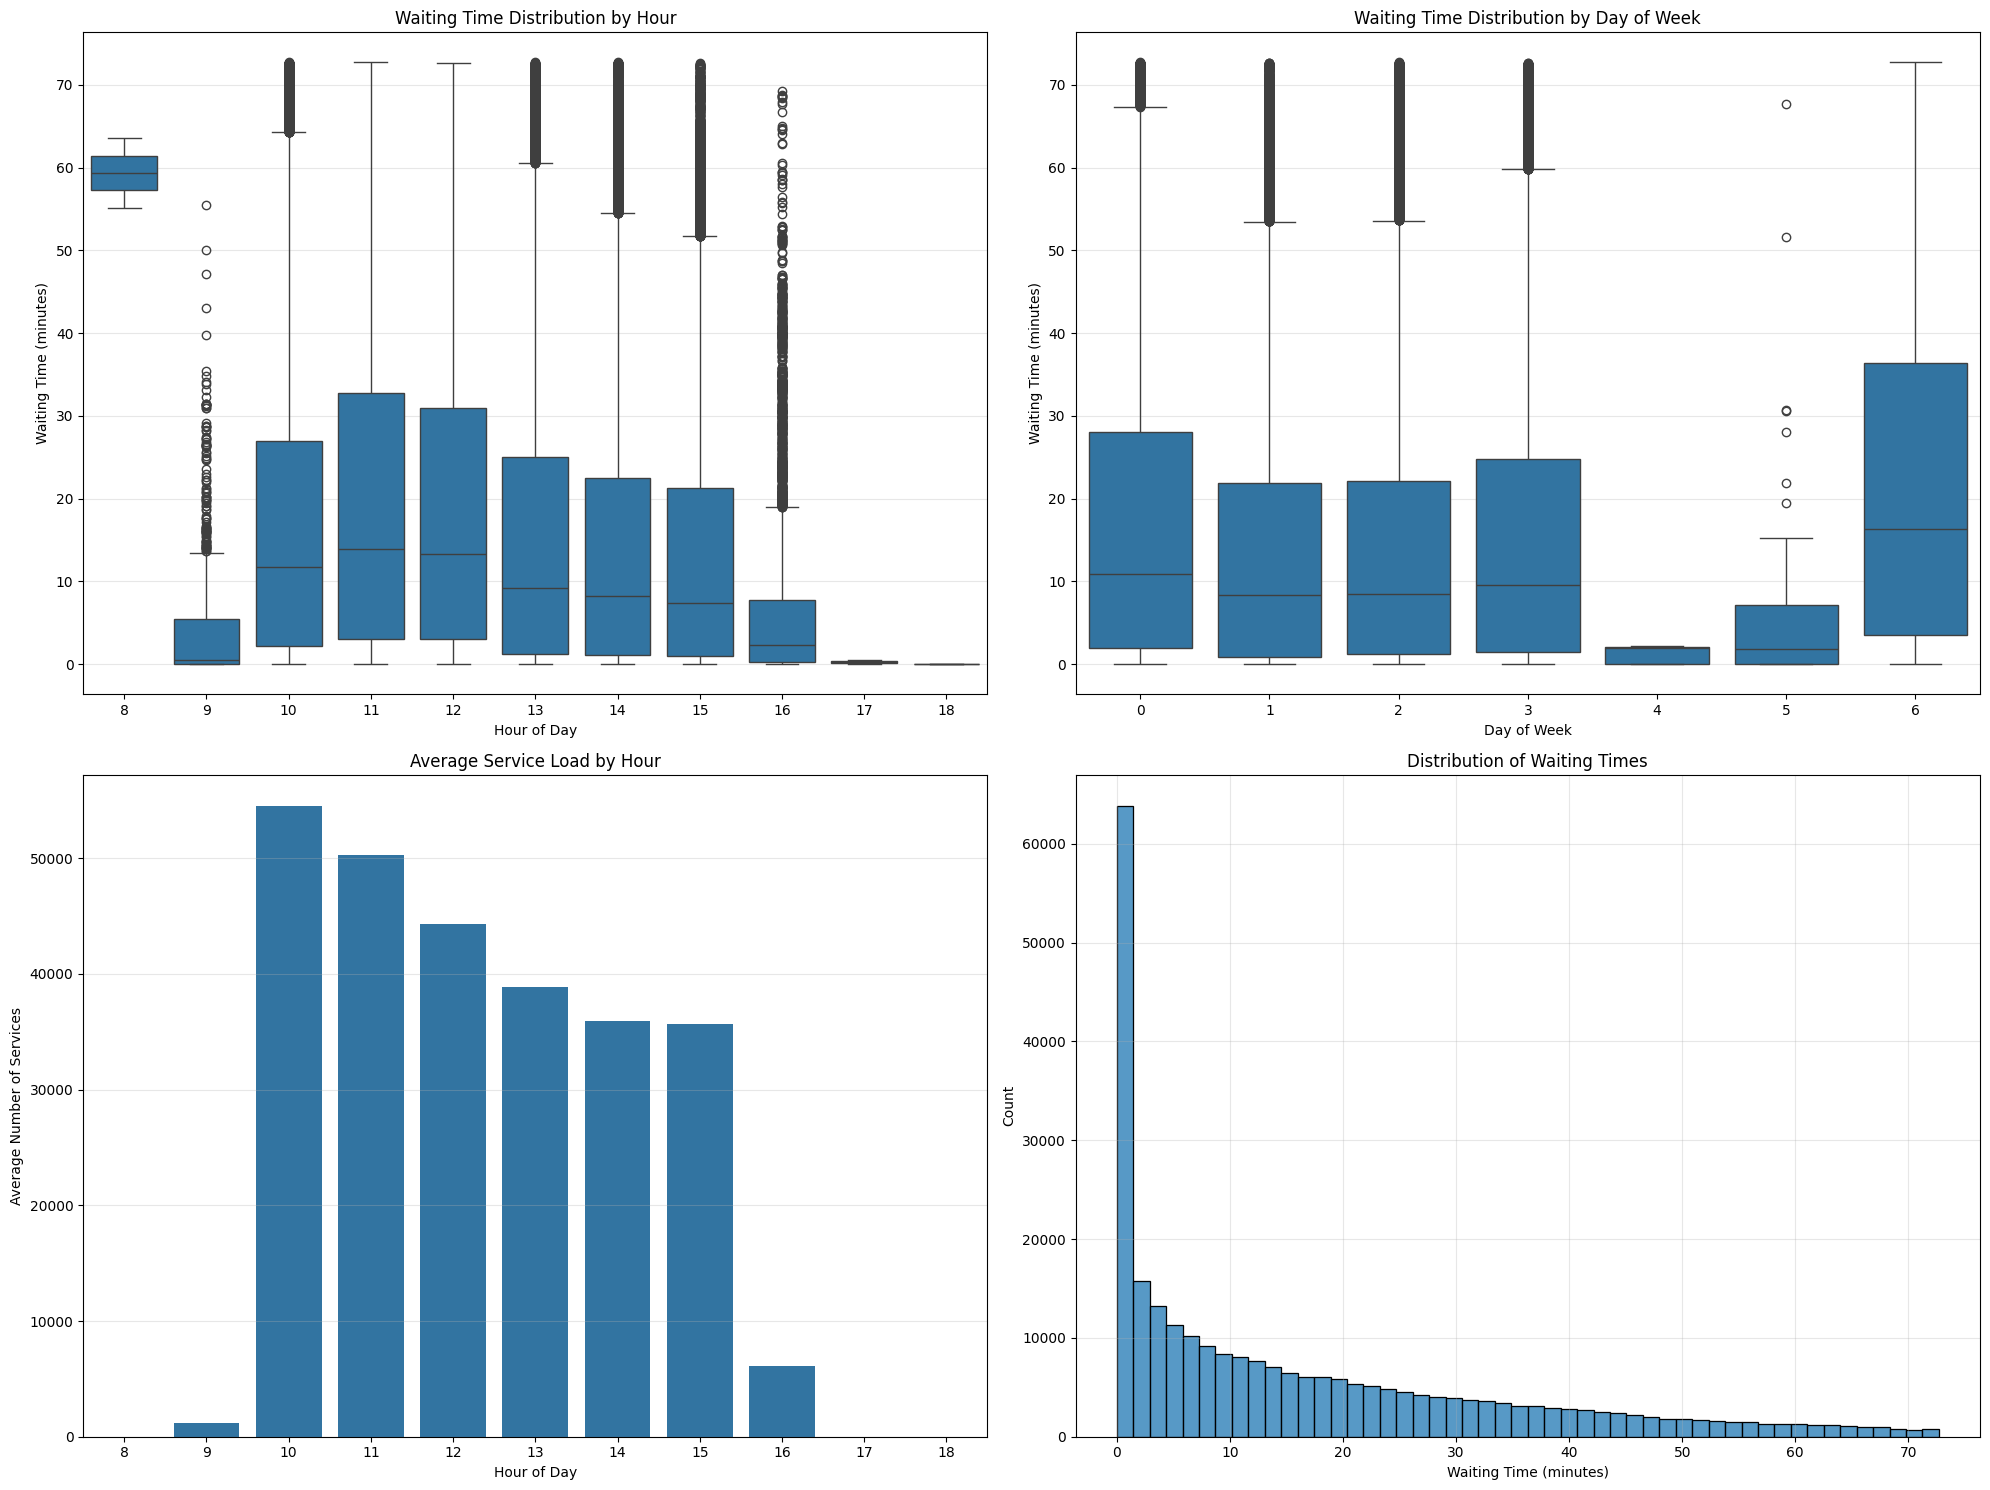

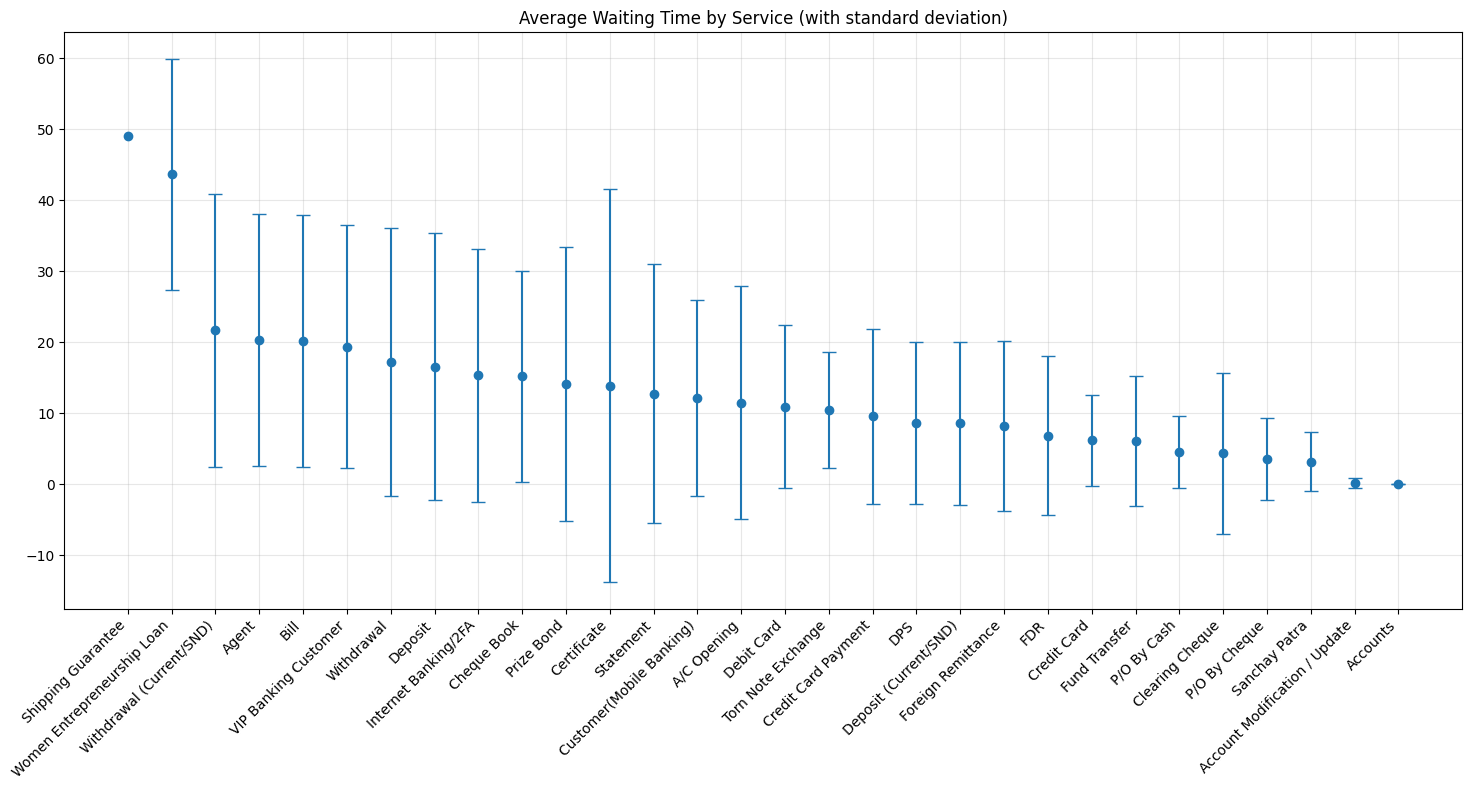

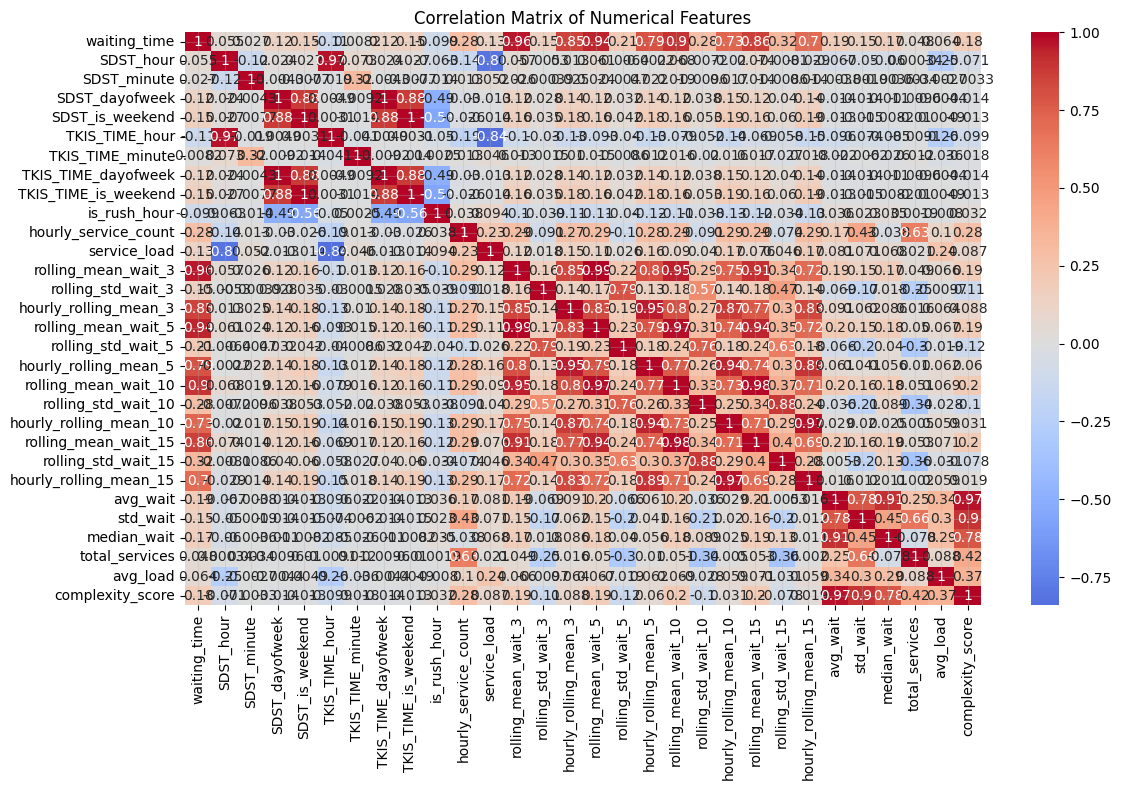

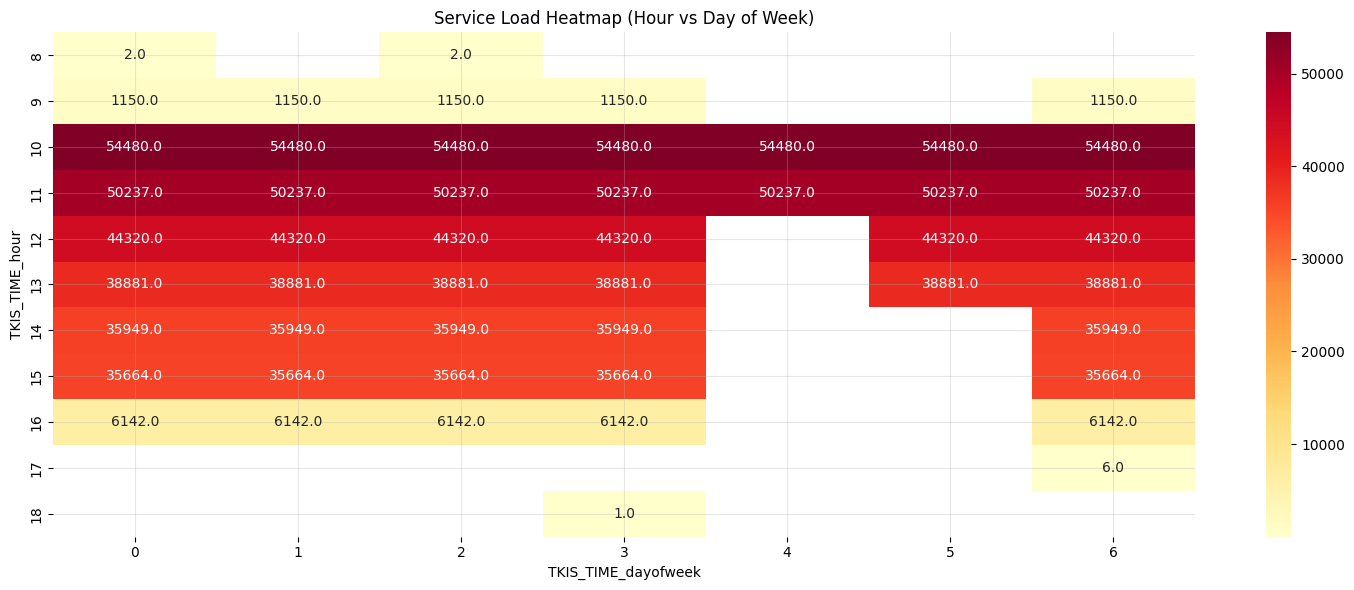


Preparing features for modeling...

Training and evaluating models...

Training CatBoost...
0:	learn: 11.3753130	total: 94.8ms	remaining: 56.8s
0:	learn: 11.8441938	total: 131ms	remaining: 1m 18s
0:	learn: 13.5291448	total: 96.7ms	remaining: 57.9s
0:	learn: 15.4994663	total: 140ms	remaining: 1m 24s
0:	learn: 16.7828158	total: 262ms	remaining: 2m 36s
100:	learn: 3.3825619	total: 5.01s	remaining: 24.8s
100:	learn: 3.2453492	total: 7.67s	remaining: 37.9s
100:	learn: 3.5742563	total: 8.63s	remaining: 42.6s
200:	learn: 2.6426077	total: 9.99s	remaining: 19.8s
100:	learn: 4.1882016	total: 10.5s	remaining: 51.7s
100:	learn: 4.5449348	total: 12.8s	remaining: 1m 3s
200:	learn: 2.4933660	total: 14.5s	remaining: 28.9s
300:	learn: 2.4494645	total: 15.5s	remaining: 15.4s
200:	learn: 2.7398427	total: 17.5s	remaining: 34.8s
200:	learn: 3.2857438	total: 19.9s	remaining: 39.4s
400:	learn: 2.3340575	total: 20.6s	remaining: 10.2s
300:	learn: 2.3350417	total: 21.5s	remaining: 21.4s
200:	learn: 3.6042219	t

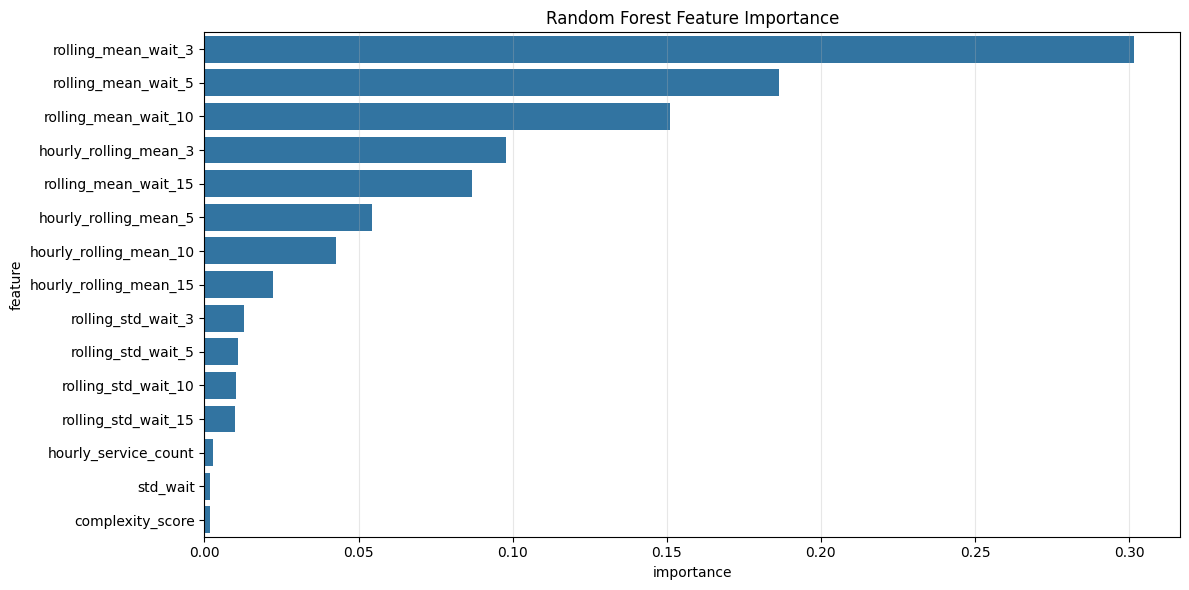


Top 10 Most Important Features (Random Forest):
                   feature  importance
12     rolling_mean_wait_3    0.301444
15     rolling_mean_wait_5    0.186317
18    rolling_mean_wait_10    0.151193
14   hourly_rolling_mean_3    0.097968
21    rolling_mean_wait_15    0.086772
17   hourly_rolling_mean_5    0.054230
20  hourly_rolling_mean_10    0.042772
23  hourly_rolling_mean_15    0.022262
13      rolling_std_wait_3    0.012744
16      rolling_std_wait_5    0.010862

Analyzing Model Performance...


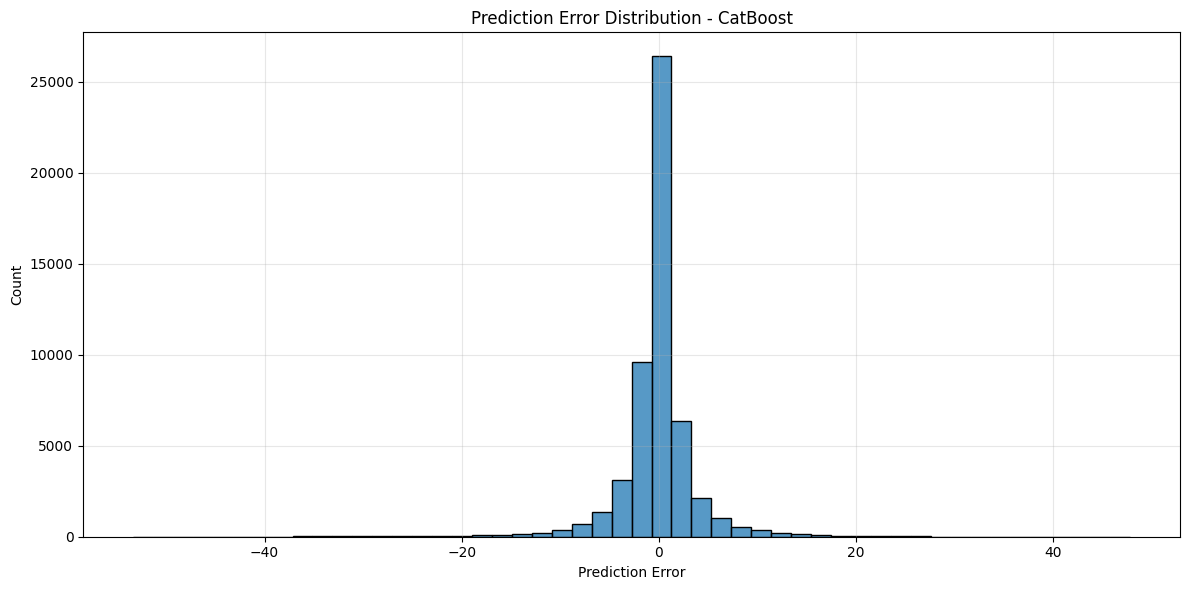


Error Statistics for CatBoost:
Mean Error: -0.1192
Error Standard Deviation: 4.1101
Error Range: [-53.3549, 47.8504]


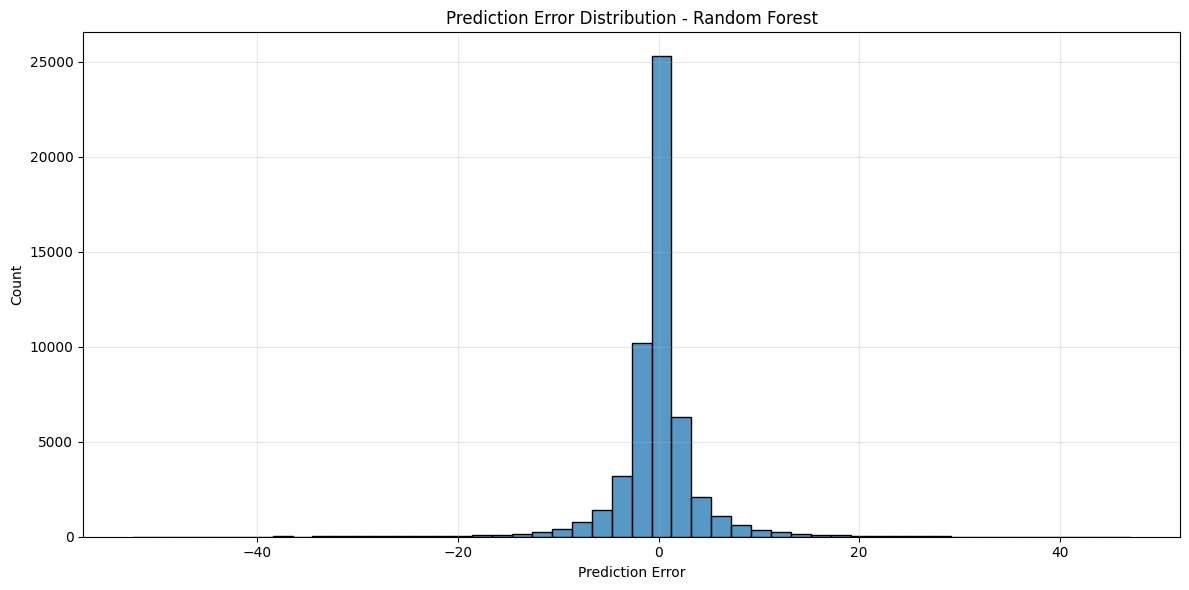


Error Statistics for Random Forest:
Mean Error: -0.1522
Error Standard Deviation: 4.2199
Error Range: [-52.4050, 47.0319]


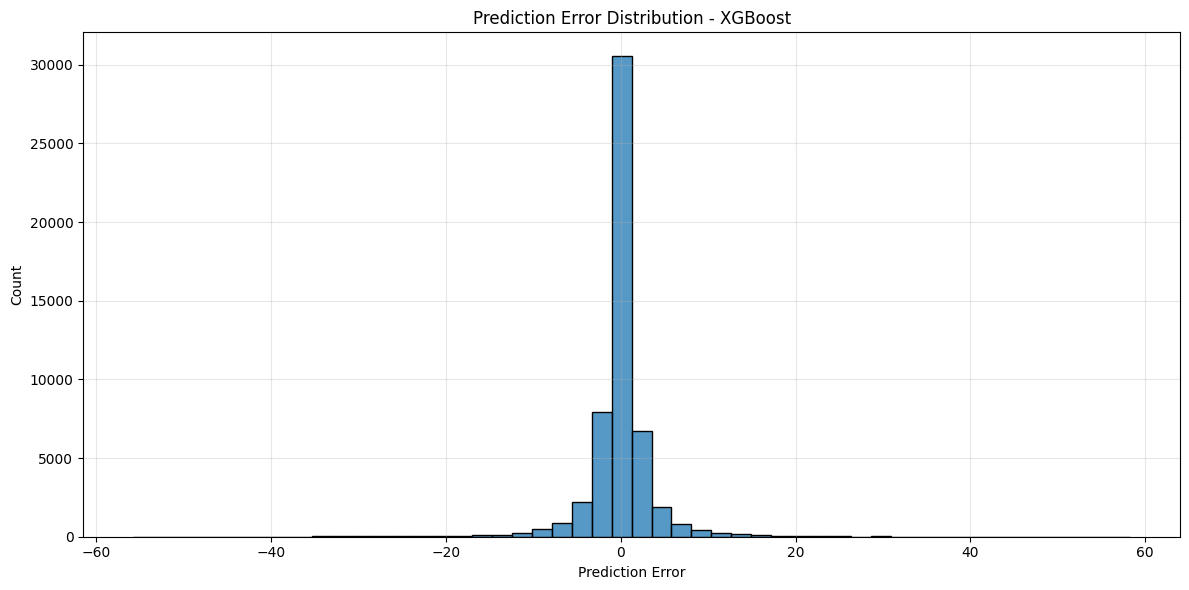


Error Statistics for XGBoost:
Mean Error: -0.0603
Error Standard Deviation: 3.9677
Error Range: [-55.8190, 58.2894]


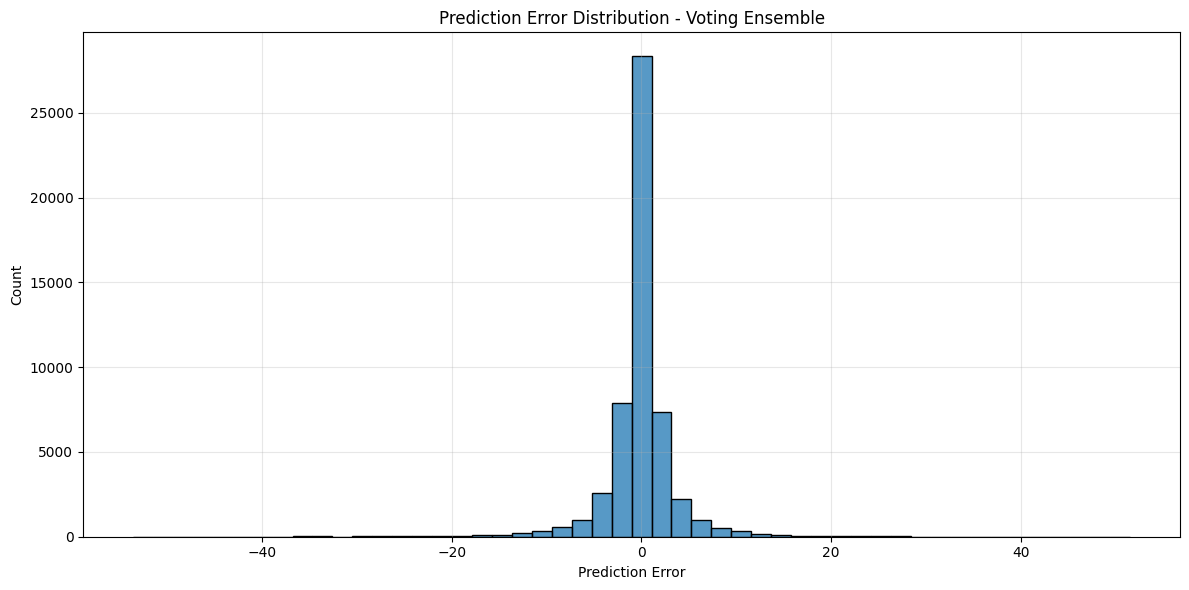


Error Statistics for Voting Ensemble:
Mean Error: -0.1023
Error Standard Deviation: 4.0167
Error Range: [-53.6426, 51.5563]

Analysis completed successfully!

Final Model Performance Summary:
--------------------------------------------------

CatBoost:
MSE: 16.9071
RMSE: 4.1118
MAE: 2.1609
R2: 0.9515
CV_RMSE: 3.6363
CV_RMSE_STD: 0.8399

Random Forest:
MSE: 17.8310
RMSE: 4.2227
MAE: 2.2341
R2: 0.9489
CV_RMSE: 3.7947
CV_RMSE_STD: 0.8789

XGBoost:
MSE: 15.7462
RMSE: 3.9682
MAE: 1.9716
R2: 0.9549
CV_RMSE: 3.5584
CV_RMSE_STD: 0.8550

Voting Ensemble:
MSE: 16.1441
RMSE: 4.0180
MAE: 2.0641
R2: 0.9537
CV_RMSE: 3.5738
CV_RMSE_STD: 0.8451


In [11]:
if __name__ == "__main__":
    # Configuration
    csv_path = "dbbl_shantinagar.csv"  # Replace with your data file path
    
    # Execute main function
    try:
        print("Starting waiting time analysis...")
        models, results, processed_data = main(csv_path)
        print("\nAnalysis completed successfully!")
        
        # Print final summary
        print("\nFinal Model Performance Summary:")
        print("-" * 50)
        for model_name, metrics in results.items():
            print(f"\n{model_name}:")
            for metric, value in metrics.items():
                print(f"{metric.upper()}: {value:.4f}")
        
    except Exception as e:
        print(f"Error: {str(e)}")